In [3]:
import os
import math
import keras
import pickle
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import Sequence

from keras.optimizers import Adam
from prettytable import PrettyTable
from keras import optimizers, metrics
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from keras import layers, models, applications
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import ResNet50, EfficientNetB1
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report


Shape of File: (2,)
Shape of Axion: (64, 64)
Mass: 6.0568785229063085e-24


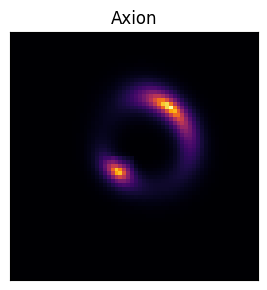

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

folder_path = '/kaggle/input/test-model-3/Model_III/axion'
title = 'Axion'

file_name = os.listdir(folder_path)[7]
file_path = os.path.join(folder_path, file_name)
loaded_file = np.load(file_path, allow_pickle=True)
print(f'Shape of File: {loaded_file.shape}') 

img_array = loaded_file[0]
mass = loaded_file[1]
print(f'Shape of Axion: {loaded_file[0].shape}') 
print('Mass:',mass)
axs.imshow(img_array, cmap='inferno')
axs.set_title(title)
axs.set_xticks([])
axs.set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
# Algorithm hyperparameters
input_shape = (64, 64, 3)
num_epochs = 20
batch_size = 256 
width = 128
temperature = 0.1
queue_size = 10000

contrastive_augmentation_rotation = {"factor": 0.5,"name": "contrastive_augmenter_rotation"}
contrastive_augmentation_gaussian = {"std_dev": 0.1,"name": "contrastive_augmenter_gaussian"} # Std_dev = 0.04 for rgb and 0.001 for 1 channel


# classification_augmentation = {"brightness": 0.1,"name": "classification_augmenter","scale": (0.5, 3.0),}

# total_samples = sum([len(files) for r, d, files in os.walk(data_path)])
# steps_per_epoch = total_samples // batch_size
# validation_steps = total_samples // batch_size


In [6]:
classes = ['axion']
class_indices = {class_name: idx for idx, class_name in enumerate(classes)}

def image_generator(files, batch_size = batch_size):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            class_name = os.path.basename(os.path.dirname(input_path))
            label = class_indices[class_name]
            data = np.load(input_path, allow_pickle=True)
            input = data[0][..., np.newaxis]  # AXION ONLY
            mass = data[1]
            img_3d = np.repeat(input, 3, axis=-1)  # For RGB channel
            img_3d = (img_3d - np.min(img_3d)) / (np.max(img_3d) - np.min(img_3d))  # For RGB channel
            batch_input.append(img_3d)  # For RGB channel
            batch_output.append(mass)

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        # Take log10 of batch_y
        batch_y_log10 = np.log10(batch_y)

        yield (batch_x, batch_y_log10)

# Get all file paths in the data_path
data_path = '/kaggle/input/test-model-3/Model_III/' 
file_paths = []
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    file_paths += [os.path.join(class_dir, file) for file in os.listdir(class_dir)]


train_files, test_files = train_test_split(file_paths, test_size=0.1, random_state=69)

train_generator = image_generator(train_files,  batch_size=batch_size)
test_generator = image_generator(test_files, batch_size=batch_size)

total_samples = len(train_files)
steps_per_epoch = total_samples // batch_size
total_validation_samples = len(test_files)
validation_steps = total_validation_samples // batch_size

Array Range: 0.0, 1.0
Sample Image of Axion


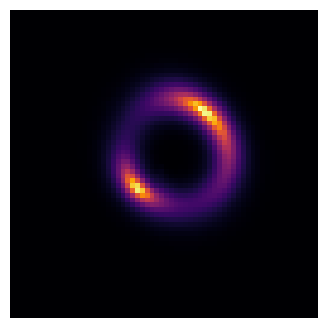

Image shape: (64, 64, 3)
Log Mass: -22.516257242236293


In [7]:
image_sample, mass_sample = next(train_generator)
print(f'Array Range: {np.min(image_sample[0])}, {np.max(image_sample[0])}')
print(f'Sample Image of Axion')
plt.figure(figsize=(4,4))
plt.imshow(np.mean(image_sample[0], axis=2), cmap='inferno') # np.mean() is used to convert the rgb image to greyscale so we can apply cmap to it.
plt.axis('off')
plt.show()
print(f'Image shape: {image_sample[1].shape}\nLog Mass: {mass_sample[1]}')


In [8]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images
    
class RandomGaussianNoise(layers.Layer):
    def __init__(self, std_dev):
        super().__init__()
        self.std_dev = std_dev

    def add_gaussian_noise(self, images):
        noise = tf.random.normal(shape=tf.shape(images), mean=0., stddev=self.std_dev)
        return tf.clip_by_value(images + noise, 0, 1)

    def call(self, images):
        images = self.add_gaussian_noise(images)
        return images

    
    
def get_augmenter_only_gaussian(std_dev, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            # layers.Rescaling(1 / 255), # Only for Single Channel Images
#             layers.RandomRotation(1), # Not needed for now
            RandomGaussianNoise(std_dev=std_dev),
#             RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
#             RandomBrightness(brightness=brightness),
        ],
        name=name,)

def get_augmenter_only_rotation(factor, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.RandomRotation(factor), 
        ],
        name=name,)

class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness
    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)
    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness),)
    def call(self, images):
        images = self.random_brightness(images)
        return images 

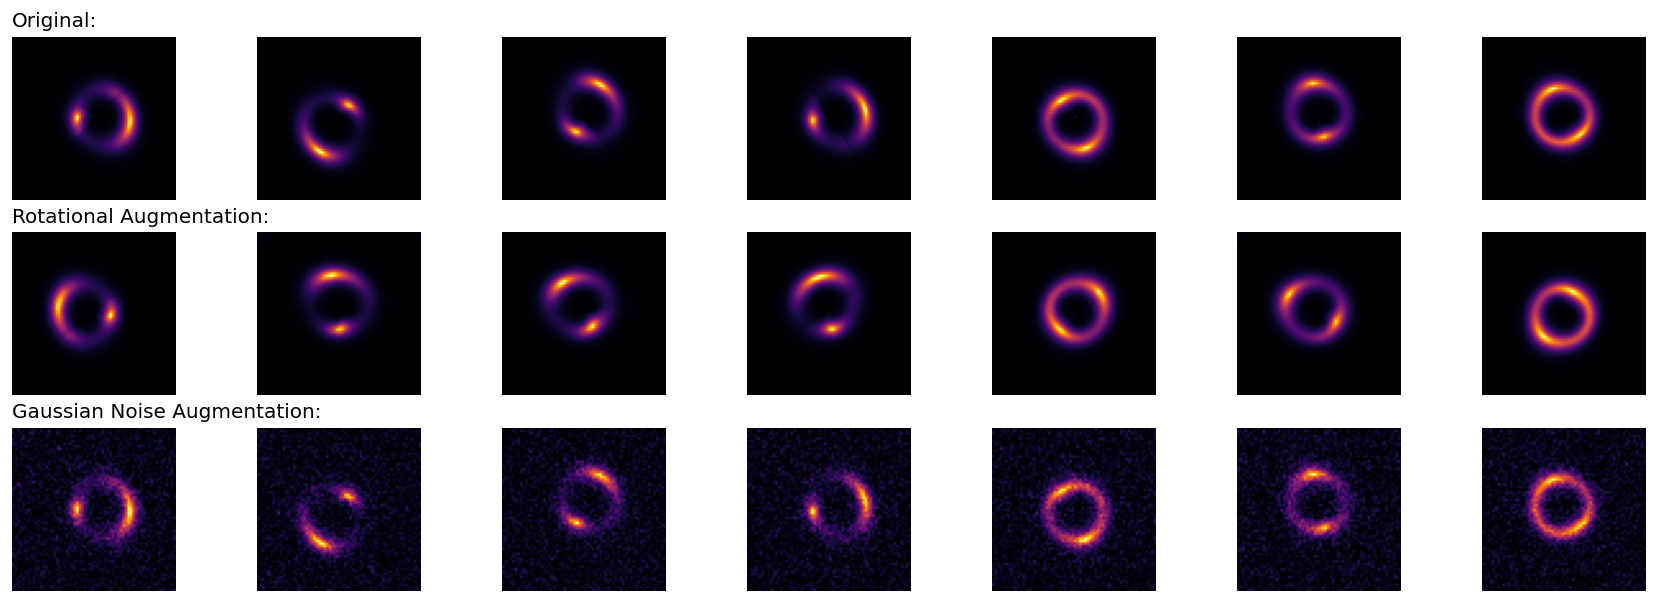

In [9]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(train_generator)[0][:num_images]
    augmented_images = zip(
        images,
        get_augmenter_only_rotation(**contrastive_augmentation_rotation)(images),
        get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)(images),
    )
    row_titles = [
        "Original:",
        "Rotational Augmentation:",
        "Gaussian Noise Augmentation:",
    ]
    plt.figure(figsize=(18, 6), dpi=120)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(3, num_images, row * num_images + column + 1)
            plt.imshow(np.mean(image, axis=2), cmap='inferno')
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")

visualize_augmentations(num_images=7)

### Baseline Training


In [10]:
def get_encoder():
    resnet = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
#     for layer in resnet.layers:
#         layer.trainable = False
    model = models.Sequential([
          resnet,
          layers.GlobalAveragePooling2D(),
#           layers.Dense(width*8,  activation='relu'), #256*8 = 2048
#           layers.BatchNormalization(), 
#           layers.Dropout(0.5),
        
#           layers.Dense(width*4,  activation='relu'), #256*4 = 1024
#           layers.BatchNormalization(),
#           layers.Dropout(0.5),
        
          layers.Dense(width,  activation='relu'), #512
#           layers.BatchNormalization(),
#           layers.Dropout(0.3),
    ])
    return model


In [11]:
baseline_model = keras.Sequential(
    [ 
        get_encoder(),
        layers.Dense(1, activation='linear'),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss='mse',
    metrics=['mae','mse'])

baseline_history = baseline_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                      validation_data=test_generator, validation_steps = validation_steps)

Epoch 1/20
104/104 [==============================] - 127s 1s/step - loss: 17.6540 - mae: 1.8894 - mse: 17.6540 - val_loss: 162.6506 - val_mae: 12.7406 - val_mse: 162.6506
Epoch 2/20
104/104 [==============================] - 60s 578ms/step - loss: 0.1565 - mae: 0.3131 - mse: 0.1565 - val_loss: 33.5098 - val_mae: 5.7607 - val_mse: 33.5098
Epoch 3/20
104/104 [==============================] - 51s 494ms/step - loss: 0.1176 - mae: 0.2692 - mse: 0.1176 - val_loss: 5.5477 - val_mae: 2.2804 - val_mse: 5.5477
Epoch 4/20
104/104 [==============================] - 45s 436ms/step - loss: 0.0964 - mae: 0.2442 - mse: 0.0964 - val_loss: 0.9724 - val_mae: 0.8201 - val_mse: 0.9724
Epoch 5/20
104/104 [==============================] - 42s 409ms/step - loss: 0.0837 - mae: 0.2259 - mse: 0.0837 - val_loss: 0.3987 - val_mae: 0.5326 - val_mse: 0.3987
Epoch 6/20
104/104 [==============================] - 40s 384ms/step - loss: 0.0708 - mae: 0.2074 - mse: 0.0708 - val_loss: 0.3776 - val_mae: 0.5206 - val_mse

In [12]:
baseline_model.save_weights('baseline_model_resnet50.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('baseline_history_resnet50.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)

### Self-Supervised Contrastive Pretraining


c_loss: Contrastive loss. It is a measure of dissimilarity between pairs of augmented images. This loss is calculated using the InfoNCE (Information Noise-Contrastive Estimation) or NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which encourages similar representations for augmented views of the same image and dissimilar representations for different images.

c_acc: Contrastive accuracy. It measures the accuracy of the contrastive predictions. In this case, it represents how well the model is able to distinguish between the representations of augmented views of the same image and different images.

p_loss: Probe loss. It is the loss for the linear probe, which is used for evaluation and downstream classification tasks. The probe loss is calculated using the sparse categorical cross-entropy loss, comparing the predicted class probabilities with the true labels.

p_acc: Probe accuracy. It represents the accuracy of the linear probe, indicating how well the model performs on the downstream classification task.

### With only Rotational

In [13]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_rotation(**contrastive_augmentation_rotation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(1)], name="linear_probe" 
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer
        self.probe_loss = keras.losses.MeanSquaredError() # Change to regression loss

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(name="c_acc")
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.MeanAbsoluteError(name="p_mae") # Change to regression metric

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, 
                                            validation_data=test_generator, validation_steps = validation_steps)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               16512     
            

In [16]:
pretraining_history = pretraining_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                                            validation_data=test_generator, validation_steps = validation_steps)

Epoch 1/30
104/104 [==============================] - 62s 592ms/step - c_loss: 1.8422 - c_acc: 0.4261 - p_loss: 154.8337 - p_mae: 8.6468 - val_p_loss: 38.7132 - val_p_mae: 5.4277
Epoch 2/30
104/104 [==============================] - 61s 582ms/step - c_loss: 1.3763 - c_acc: 0.5552 - p_loss: 40.6115 - p_mae: 5.0436 - val_p_loss: 78.9107 - val_p_mae: 7.0457
Epoch 3/30
104/104 [==============================] - 62s 596ms/step - c_loss: 0.8253 - c_acc: 0.8123 - p_loss: 44.0226 - p_mae: 4.9401 - val_p_loss: 22.3836 - val_p_mae: 3.4194
Epoch 4/30
104/104 [==============================] - 62s 600ms/step - c_loss: 0.5434 - c_acc: 0.8948 - p_loss: 28.2779 - p_mae: 4.0638 - val_p_loss: 43.9475 - val_p_mae: 4.7929
Epoch 5/30
104/104 [==============================] - 73s 703ms/step - c_loss: 0.4547 - c_acc: 0.9077 - p_loss: 44.3290 - p_mae: 5.2604 - val_p_loss: 79.5783 - val_p_mae: 5.5605
Epoch 6/30
104/104 [==============================] - 69s 662ms/step - c_loss: 0.3967 - c_acc: 0.9292 - p_los

In [17]:
pretraining_model.save_weights('pretraining_model_rotational.h5')
with open('pretraining_history_rotational.pkl', 'wb') as file:
    pickle.dump(pretraining_history.history, file)

In [18]:
finetuning_model_rotation = keras.Sequential(
    [
        pretraining_model.encoder,
        layers.Dense(1, activation='linear'),
    ],
    name="finetuning_model_rotation",
)

finetuning_model_rotation.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss='mse',
    metrics=['mae', 'mse'])
finetuning_history_rotation = finetuning_model_rotation.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                                          validation_data=test_generator, validation_steps = validation_steps)

Epoch 1/20
104/104 [==============================] - 48s 408ms/step - loss: 351.2713 - mae: 11.8073 - mse: 351.2713 - val_loss: 312.2151 - val_mae: 14.7318 - val_mse: 312.2151
Epoch 2/20
104/104 [==============================] - 42s 408ms/step - loss: 4.1388 - mae: 1.4201 - mse: 4.1388 - val_loss: 27.8763 - val_mae: 3.8045 - val_mse: 27.8763
Epoch 3/20
104/104 [==============================] - 41s 392ms/step - loss: 1.7641 - mae: 0.9661 - mse: 1.7641 - val_loss: 4.3918 - val_mae: 1.4329 - val_mse: 4.3918
Epoch 4/20
104/104 [==============================] - 41s 393ms/step - loss: 1.1423 - mae: 0.7923 - mse: 1.1423 - val_loss: 1.7432 - val_mae: 0.9746 - val_mse: 1.7432
Epoch 5/20
104/104 [==============================] - 44s 423ms/step - loss: 0.9049 - mae: 0.7206 - mse: 0.9049 - val_loss: 0.6398 - val_mae: 0.6187 - val_mse: 0.6398
Epoch 6/20
104/104 [==============================] - 52s 504ms/step - loss: 0.7270 - mae: 0.6509 - mse: 0.7270 - val_loss: 0.5663 - val_mae: 0.5838 - va

In [19]:
finetuning_model_rotation.save_weights('finetuning_model_rotation.h5')
with open('finetuning_history_rotation.pkl', 'wb') as file:
    pickle.dump(finetuning_history_rotation.history, file)

### With Gaussian blur

In [20]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(1)], name="linear_probe" # Ensure output dimension is 1
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer
        self.probe_loss = keras.losses.MeanSquaredError() # Change to regression loss

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(name="c_acc")
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.MeanAbsoluteError(name="p_mae") # Change to regression metric

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model_gaussian = ContrastiveModel()
pretraining_model_gaussian.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history_gaussian = pretraining_model_gaussian.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, 
                                            validation_data=test_generator, validation_steps = validation_steps)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               16512     
            

In [21]:
pretraining_history_gaussian = pretraining_model_gaussian.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                                            validation_data=test_generator, validation_steps = validation_steps)

Epoch 1/30
104/104 [==============================] - 90s 865ms/step - c_loss: 0.1805 - c_acc: 0.9696 - p_loss: 16.7025 - p_mae: 3.1509 - val_p_loss: 15.6176 - val_p_mae: 3.2171
Epoch 2/30
104/104 [==============================] - 97s 939ms/step - c_loss: 0.1767 - c_acc: 0.9706 - p_loss: 14.3612 - p_mae: 2.9896 - val_p_loss: 16.7242 - val_p_mae: 3.1372
Epoch 3/30
104/104 [==============================] - 85s 817ms/step - c_loss: 0.1613 - c_acc: 0.9737 - p_loss: 13.4394 - p_mae: 2.9309 - val_p_loss: 12.7013 - val_p_mae: 2.8612
Epoch 4/30
104/104 [==============================] - 81s 784ms/step - c_loss: 0.1593 - c_acc: 0.9732 - p_loss: 12.3088 - p_mae: 2.7577 - val_p_loss: 13.4262 - val_p_mae: 2.8168
Epoch 5/30
104/104 [==============================] - 81s 779ms/step - c_loss: 0.1539 - c_acc: 0.9731 - p_loss: 15.1315 - p_mae: 3.0016 - val_p_loss: 13.1467 - val_p_mae: 2.7070
Epoch 6/30
104/104 [==============================] - 82s 789ms/step - c_loss: 0.1467 - c_acc: 0.9761 - p_loss

In [22]:
pretraining_model_gaussian.save_weights('pretraining_model_gaussian.h5')
with open('pretraining_history_gaussian.pkl', 'wb') as file:
    pickle.dump(pretraining_history_gaussian.history, file)


In [23]:
finetuning_model_gaussian = keras.Sequential(
    [
        pretraining_model_gaussian.encoder,
        layers.Dense(1, activation='linear'),
    ],
    name="finetuning_model",
)
finetuning_model_gaussian.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss='mse',
    metrics='mse')

finetuning_history_gaussian = finetuning_model_gaussian.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, 
                                          validation_data=test_generator, validation_steps = validation_steps)

Epoch 1/20
104/104 [==============================] - 49s 407ms/step - loss: 34.8895 - mse: 34.8895 - val_loss: 15.3162 - val_mse: 15.3162
Epoch 2/20
104/104 [==============================] - 42s 403ms/step - loss: 2.3647 - mse: 2.3647 - val_loss: 4.3168 - val_mse: 4.3168
Epoch 3/20
104/104 [==============================] - 42s 401ms/step - loss: 1.3076 - mse: 1.3076 - val_loss: 1.7845 - val_mse: 1.7845
Epoch 4/20
104/104 [==============================] - 42s 402ms/step - loss: 0.9735 - mse: 0.9735 - val_loss: 0.9257 - val_mse: 0.9257
Epoch 5/20
104/104 [==============================] - 41s 396ms/step - loss: 0.7467 - mse: 0.7467 - val_loss: 0.6346 - val_mse: 0.6346
Epoch 6/20
104/104 [==============================] - 42s 407ms/step - loss: 0.6616 - mse: 0.6616 - val_loss: 0.4312 - val_mse: 0.4312
Epoch 7/20
104/104 [==============================] - 43s 410ms/step - loss: 0.5908 - mse: 0.5908 - val_loss: 0.5519 - val_mse: 0.5519
Epoch 8/20
104/104 [==============================]

In [24]:
finetuning_model_gaussian.save_weights('finetuning_model_gaussian.h5')
with open('finetuning_history_gaussian.pkl', 'wb') as file:
    pickle.dump(finetuning_history_gaussian.history, file)


### Results

In [25]:
# baseline_model.load_weights('/kaggle/working/baseline_model_resnet50.h5')
# finetuning_model_rotation.load_weights('/kaggle/working/finetuning_model_rotation.h5')
# finetuning_model_gaussian.load_weights('/kaggle/working/finetuning_model_gaussian.h5')

In [26]:
val_file_paths = []
for class_name in classes:
    val_class_dir = os.path.join('/kaggle/input/testset-model-iii/Model_III_test/' , class_name)
    val_file_paths += [os.path.join(val_class_dir, file) for file in os.listdir(val_class_dir)]
val_generator = image_generator(val_file_paths, batch_size = batch_size)

# baseline_model_results = baseline_model.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_rotation_results = finetuning_model_rotation.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_gaussian_results = finetuning_model_gaussian.predict(val_generator, steps=len(val_file_paths), verbose=1)

Array Range: 0.0, 1.0
Sample Image of Axion


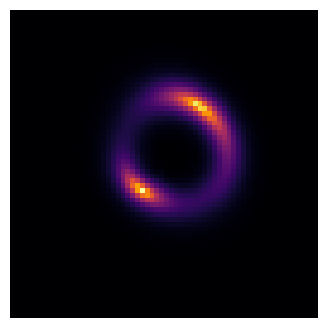

Image shape: (64, 64, 3)
Mass: -22.329100157497372


In [27]:
image_sample, mass_sample = next(val_generator)
print(f'Array Range: {np.min(image_sample[0])}, {np.max(image_sample[0])}')
print(f'Sample Image of Axion')
plt.figure(figsize=(4,4))
plt.imshow(np.mean(image_sample[0], axis=2), cmap='inferno') # np.mean() is used to convert the rgb image to greyscale so we can apply cmap to it.
plt.axis('off')
plt.show()
print(f'Image shape: {image_sample[1].shape}\nMass: {mass_sample[1]}')


In [ ]:
num_batches = len(val_file_paths) // batch_size
y_true_baseline = []
y_pred_baseline = []
y_true_finetuning_rotation = []
y_pred_finetuning_rotation = []
y_true_finetuning_gaussian = []
y_pred_finetuning_gaussian = []

for i in range(num_batches):
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

# Here is the extra logic for handling the last smaller batch
if len(val_file_paths) % batch_size != 0:
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

y_true_baseline = np.array(y_true_baseline)
y_pred_baseline = np.array(y_pred_baseline)
y_true_finetuning_rotation = np.array(y_true_finetuning_rotation)
y_pred_finetuning_rotation = np.array(y_pred_finetuning_rotation)
y_true_finetuning_gaussian = np.array(y_true_finetuning_gaussian)
y_pred_finetuning_gaussian = np.array(y_pred_finetuning_gaussian)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE, MSE, and R2 for the baseline model
mae_baseline = mean_absolute_error(y_true_baseline, y_pred_baseline)
mse_baseline = mean_squared_error(y_true_baseline, y_pred_baseline)
r2_baseline = r2_score(y_true_baseline, y_pred_baseline)

# Calculate MAE, MSE, and R2 for the fine-tuning with rotation model
mae_finetuning_rotation = mean_absolute_error(y_true_finetuning_rotation, y_pred_finetuning_rotation)
mse_finetuning_rotation = mean_squared_error(y_true_finetuning_rotation, y_pred_finetuning_rotation)
r2_finetuning_rotation = r2_score(y_true_finetuning_rotation, y_pred_finetuning_rotation)

# Calculate MAE, MSE, and R2 for the fine-tuning with Gaussian model
mae_finetuning_gaussian = mean_absolute_error(y_true_finetuning_gaussian, y_pred_finetuning_gaussian)
mse_finetuning_gaussian = mean_squared_error(y_true_finetuning_gaussian, y_pred_finetuning_gaussian)
r2_finetuning_gaussian = r2_score(y_true_finetuning_gaussian, y_pred_finetuning_gaussian)

# Print the metrics in scientific notation
print("Regression Metrics (MODEL II: Containing 5000 samples per class):\n")

print(f"MAE (Baseline): {mae_baseline:.1e}")
print(f"MSE (Baseline): {mse_baseline:.1e}")
print(f"R2 (Baseline): {r2_baseline:.1e}")

print(f"\nMAE (Finetuning Rotation): {mae_finetuning_rotation:.1e}")
print(f"MSE (Finetuning Rotation): {mse_finetuning_rotation:.1e}")
print(f"R2 (Finetuning Rotation): {r2_finetuning_rotation:.1e}")

print(f"\nMAE (Finetuning Gaussian): {mae_finetuning_gaussian:.1e}")
print(f"MSE (Finetuning Gaussian): {mse_finetuning_gaussian:.1e}")
print(f"R2 (Finetuning Gaussian): {r2_finetuning_gaussian:.1e}")



Regression Metrics (MODEL II: Containing 5000 samples per class):

MAE (Baseline): 3.7e-01
MSE (Baseline): 1.9e-01
R2 (Baseline): 4.3e-01

MAE (Finetuning Rotation): 3.0e-01
MSE (Finetuning Rotation): 1.4e-01
R2 (Finetuning Rotation): 5.7e-01

MAE (Finetuning Gaussian): 4.0e-01
MSE (Finetuning Gaussian): 2.4e-01
R2 (Finetuning Gaussian): 2.6e-01


In [30]:
y_pred_baseline_reshaped  = y_pred_baseline.reshape(-1) # Converts (5120,1) to (5120,)
print(y_pred_baseline_reshaped.shape, y_true_baseline.shape)
y_pred_finetuning_rotation_reshaped  = y_pred_finetuning_rotation.reshape(-1) # Converts (5120,1) to (5120,)
print(y_pred_finetuning_rotation_reshaped.shape, y_true_finetuning_rotation.shape)
y_pred_finetuning_gaussian_reshaped  = y_pred_finetuning_gaussian.reshape(-1) # Converts (5120,1) to (5120,)
print(y_pred_finetuning_gaussian_reshaped.shape, y_true_finetuning_gaussian.shape)

(5120,) (5120,)
(5120,) (5120,)
(5120,) (5120,)


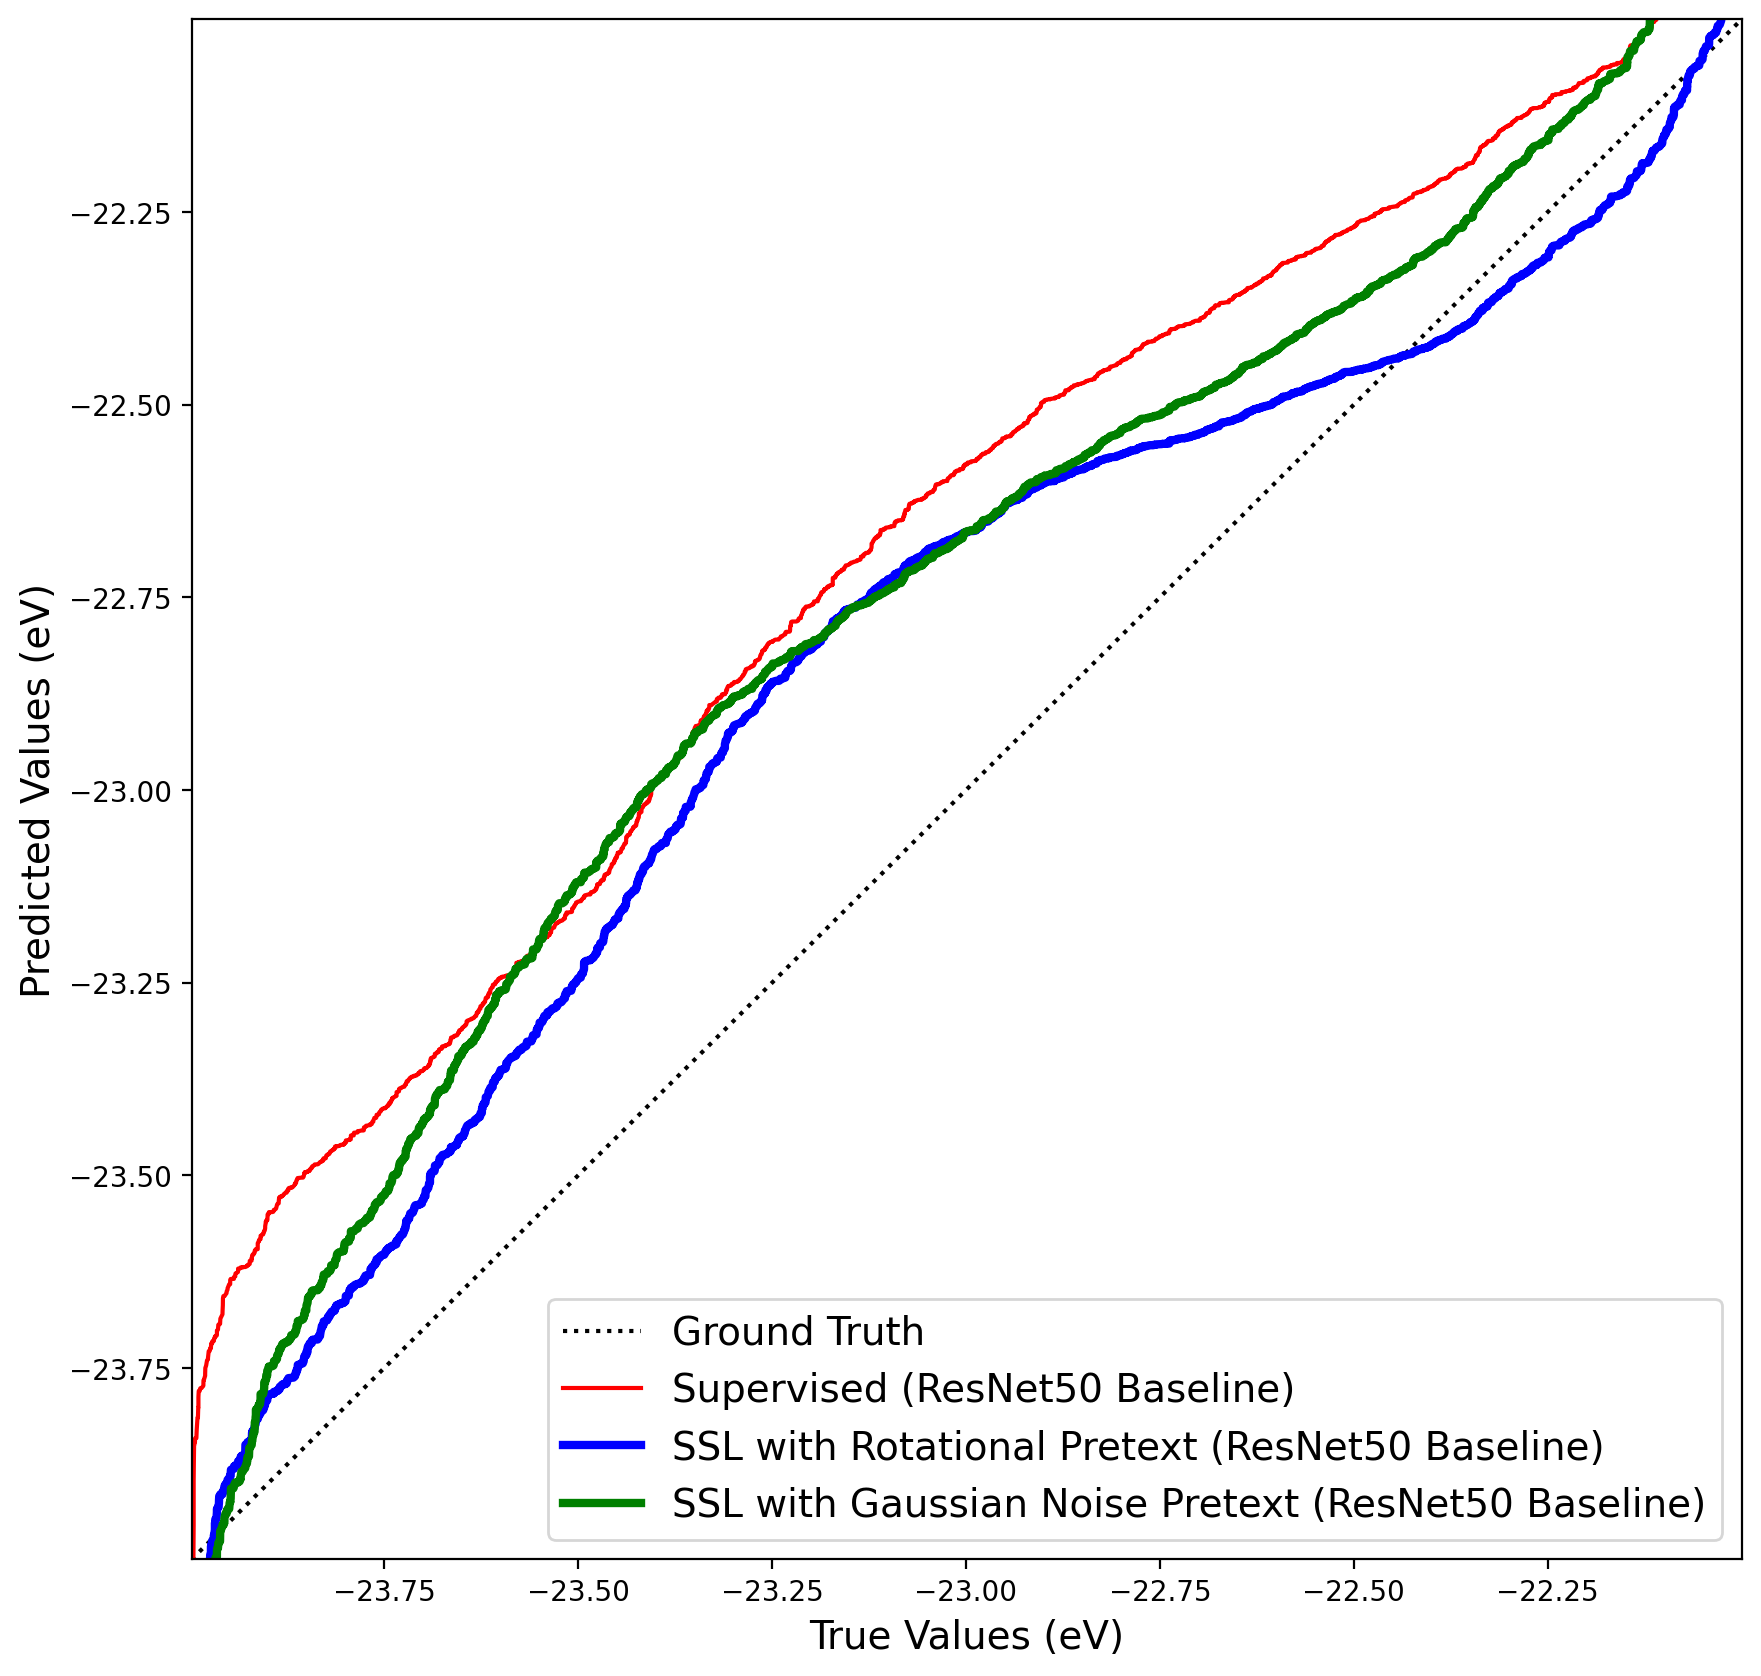

In [94]:
# Determine the axis limits based on the true labels
min_limit = np.min(y_true_baseline)
max_limit = np.max(y_true_baseline)

plt.figure(figsize=(10, 10), dpi= 200)
plt.plot(np.sort(y_true_baseline), np.sort(y_true_baseline), color='black', linestyle='dotted',  label='Ground Truth')
plt.plot(np.sort(y_true_baseline), np.sort(y_pred_baseline_reshaped), color='red', label='Supervised (ResNet50 Baseline)')
plt.plot(np.sort(y_true_finetuning_rotation), np.sort(y_pred_finetuning_rotation_reshaped), color='blue', linewidth = 3, label='SSL with Rotational Pretext (ResNet50 Baseline)')
plt.plot(np.sort(y_true_finetuning_gaussian), np.sort(y_pred_finetuning_gaussian_reshaped), color='green', linewidth = 3, label='SSL with Gaussian Noise Pretext (ResNet50 Baseline)')

# Axis labels and limits
plt.xlabel('True Values (eV)', fontsize=14)
plt.ylabel('Predicted Values (eV)', fontsize=14)
plt.xlim([min_limit, max_limit])
plt.ylim([min_limit, max_limit])

plt.legend(fontsize=14)
plt.show()


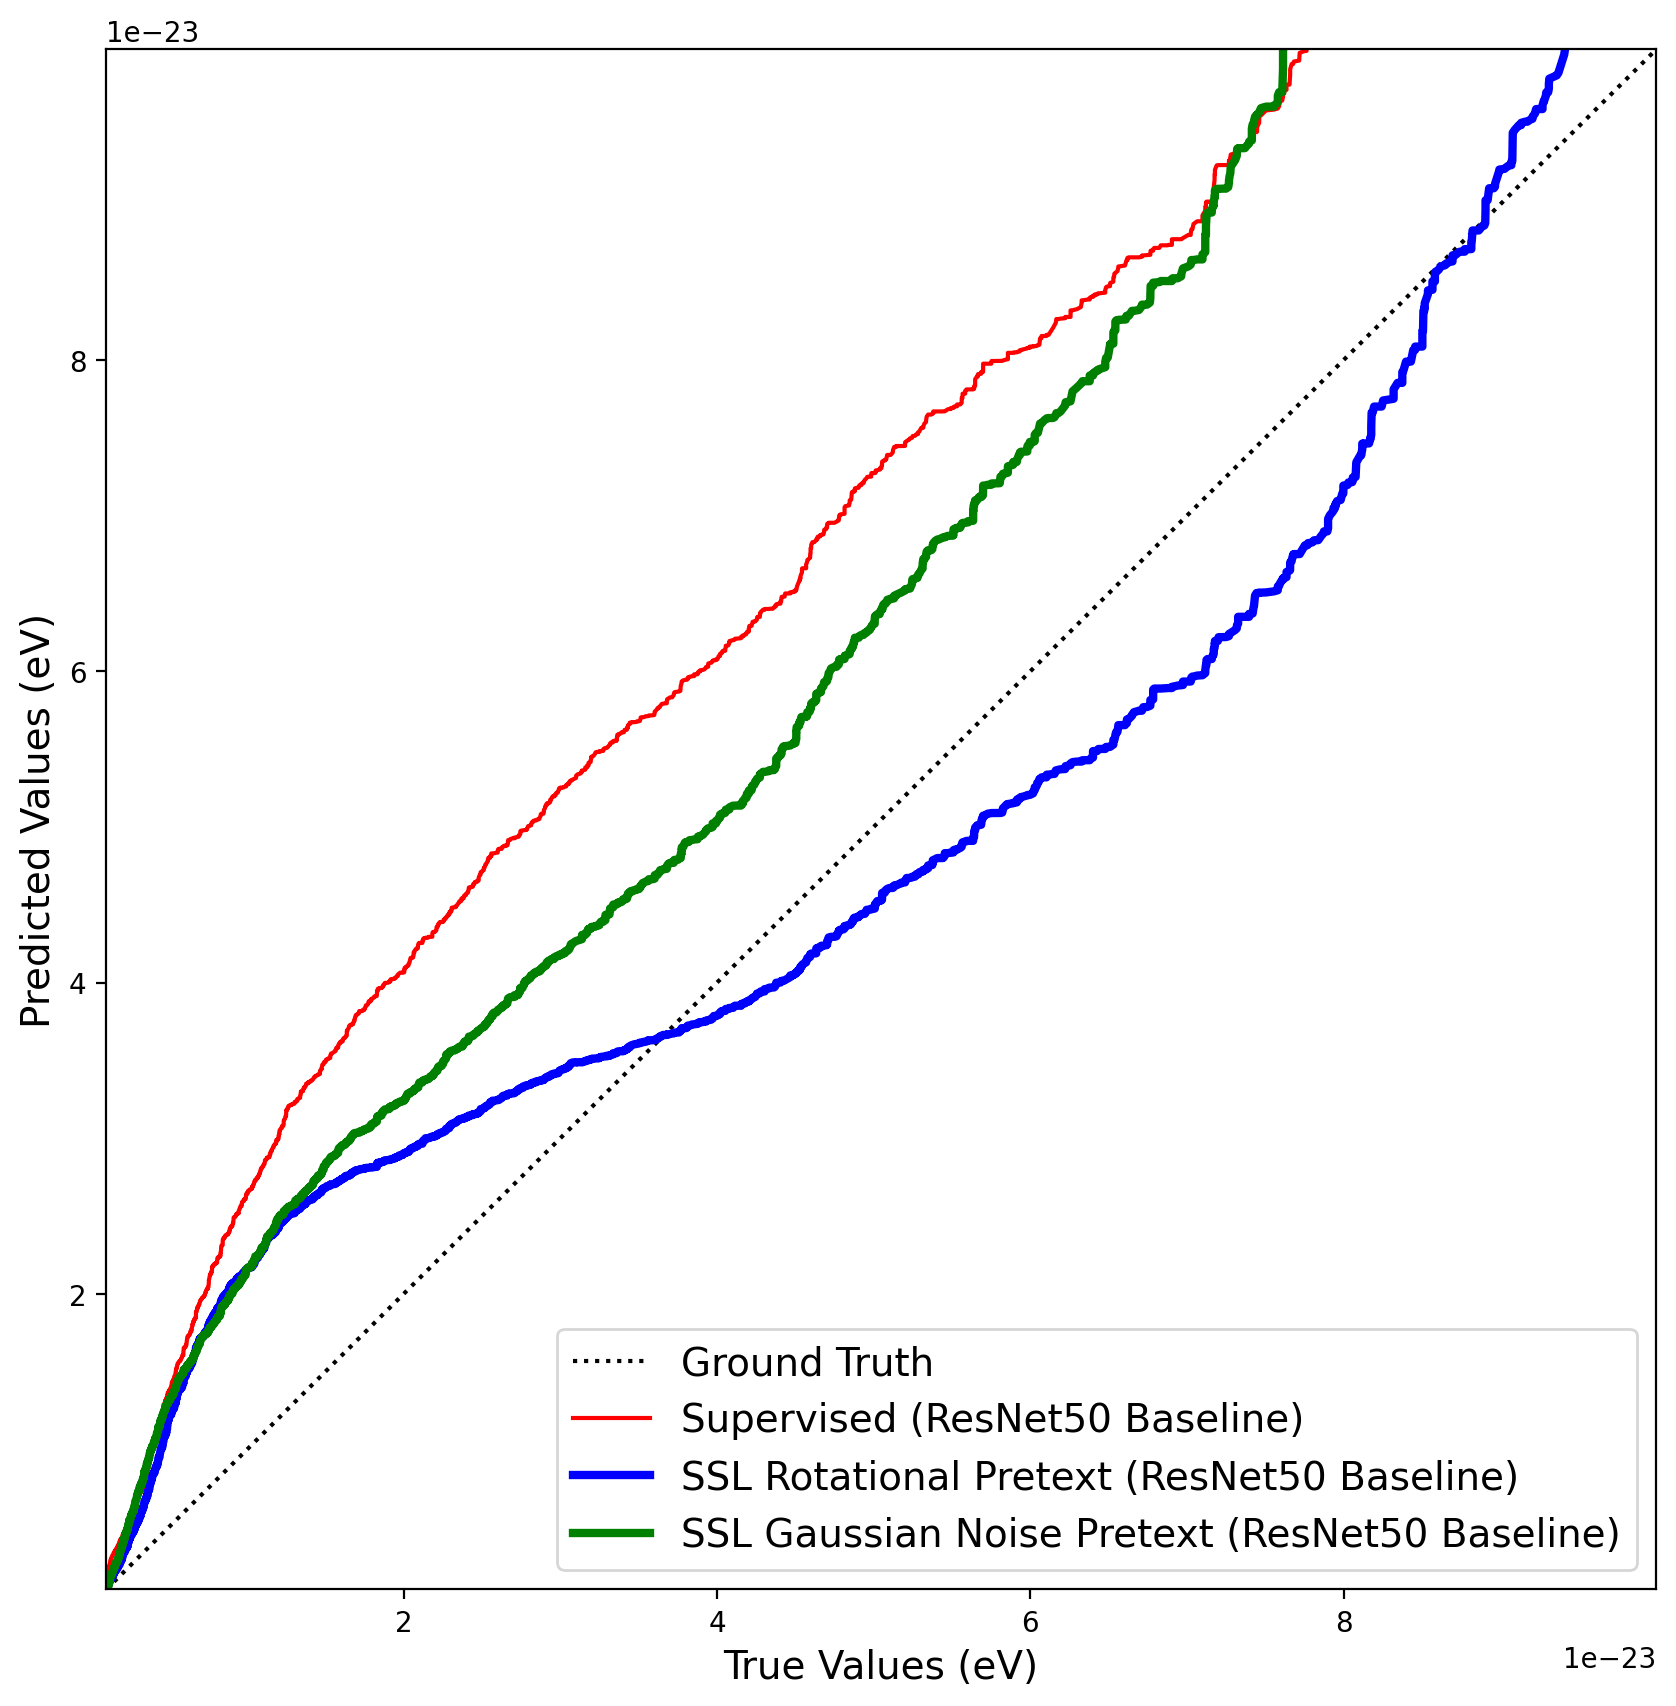

In [93]:
# Un-log code here
y_true_baseline_original = 10 ** y_true_baseline
y_pred_baseline_reshaped_original = 10 ** y_pred_baseline_reshaped
y_true_finetuning_rotation_original = 10 ** y_true_finetuning_rotation
y_pred_finetuning_rotation_reshaped_original = 10 ** y_pred_finetuning_rotation_reshaped
y_true_finetuning_gaussian_original = 10 ** y_true_finetuning_gaussian
y_pred_finetuning_gaussian_reshaped_original = 10 ** y_pred_finetuning_gaussian_reshaped

# Determine the axis limits based on the true labels
min_limit = np.min(y_true_baseline_original)
max_limit = np.max(y_true_baseline_original)

# Plotting
plt.figure(figsize=(10, 10), dpi= 200)
plt.plot(np.sort(y_true_baseline_original), np.sort(y_true_baseline_original), color='black', linestyle='dotted',  label='Ground Truth')
plt.plot(np.sort(y_true_baseline_original), np.sort(y_pred_baseline_reshaped_original), color='red', label='Supervised (ResNet50 Baseline)')
plt.plot(np.sort(y_true_finetuning_rotation_original), np.sort(y_pred_finetuning_rotation_reshaped_original), color='blue', linewidth = 3, label='SSL Rotational Pretext (ResNet50 Baseline)')
plt.plot(np.sort(y_true_finetuning_gaussian_original), np.sort(y_pred_finetuning_gaussian_reshaped_original), color='green', linewidth = 3, label='SSL Gaussian Noise Pretext (ResNet50 Baseline)')

# Axis labels and limits
plt.xlabel('True Values (eV)', fontsize=14)
plt.ylabel('Predicted Values (eV)', fontsize=14)
plt.xlim([min_limit, max_limit])
plt.ylim([min_limit, max_limit])

plt.legend(fontsize=14)
plt.show()

Array Range: 0.0, 1.0
Sample Image of Axion


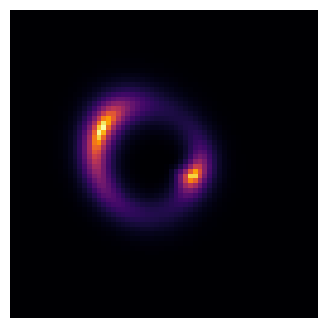

Image shape: (64, 64, 3)
+-------------------------+---------------------+------------------------+
|         Metrics         |       Sample 1      |        Sample 2        |
+-------------------------+---------------------+------------------------+
|    Denormalized Mass    | 4.3425151822221e-23 | 1.1839665284483675e-24 |
| Predicted Mass Baseline |    8.2319466e-23    |     2.0578677e-24      |
| Predicted Mass Rotation |    2.8480892e-23    |     2.0542827e-24      |
| Predicted Mass Gaussian |    9.2182246e-23    |     1.4750348e-24      |
+-------------------------+---------------------+------------------------+


In [41]:
image_sample, mass_sample = next(train_generator)
sample_id = 0
sample_id2 = 1
print(f'Array Range: {np.min(image_sample[sample_id])}, {np.max(image_sample[sample_id])}')
print(f'Sample Image of Axion')
plt.figure(figsize=(4,4))
plt.imshow(np.mean(image_sample[sample_id], axis=2), cmap='inferno') # np.mean() is used to convert the rgb image to greyscale so we can apply cmap to it.
plt.axis('off')
plt.show()
print(f'Image shape: {image_sample[sample_id].shape}')

denormalized_mass = 10 ** mass_sample[sample_id]
predicted_mass = 10 ** baseline_model.predict(np.expand_dims(image_sample[sample_id], axis=0),verbose = 0)
predicted_mass_rotation = 10 ** finetuning_model_rotation.predict(np.expand_dims(image_sample[sample_id], axis=0),verbose = 0)
predicted_mass_gaussian = 10 **finetuning_model_gaussian.predict(np.expand_dims(image_sample[sample_id], axis=0),verbose = 0)

denormalized_mass2 = 10 ** mass_sample[sample_id2]
predicted_mass2 = 10 ** baseline_model.predict(np.expand_dims(image_sample[sample_id2], axis=0),verbose = 0)
predicted_mass_rotation2 = 10 ** finetuning_model_rotation.predict(np.expand_dims(image_sample[sample_id2], axis=0),verbose = 0)
predicted_mass_gaussian2 = 10 ** finetuning_model_gaussian.predict(np.expand_dims(image_sample[sample_id2], axis=0),verbose = 0)
# Create a new PrettyTable object
table = PrettyTable()

# Add column names
table.field_names = ["Metrics", "Sample 1","Sample 2"]


# Add rows
table.add_row(["Denormalized Mass", denormalized_mass, denormalized_mass2])
table.add_row(["Predicted Mass Baseline", predicted_mass[0][0], predicted_mass2[0][0]])
table.add_row(["Predicted Mass Rotation", predicted_mass_rotation[0][0], predicted_mass_rotation2[0][0]])
table.add_row(["Predicted Mass Gaussian", predicted_mass_gaussian[0][0], predicted_mass_gaussian2[0][0]])

print(table)


In [42]:
!zip -r model3_regression_weights.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/finetuning_model_gaussian.h5 (deflated 8%)
  adding: kaggle/working/pretraining_model_gaussian.h5 (deflated 8%)
  adding: kaggle/working/pretraining_model_rotational.h5 (deflated 8%)
  adding: kaggle/working/finetuning_model_rotation.h5 (deflated 8%)
  adding: kaggle/working/finetuning_history_gaussian.pkl (deflated 66%)
  adding: kaggle/working/baseline_history_resnet50.pkl (deflated 58%)
  adding: kaggle/working/finetuning_history_rotation.pkl (deflated 58%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/pretraining_history_rotational.pkl (deflated 47%)
  adding: kaggle/working/pretraining_history_gaussian.pkl (deflated 49%)
  adding: kaggle/working/baseline_model_resnet50.h5 (deflated 8%)
